In [53]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning
from joblib import Parallel, delayed

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA,SparsePCA,MiniBatchSparsePCA
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=np.array([item for subl in info['petID'] for subsubl in subl for item in subsubl])

# define MSMdir
data_type = 'bpnd.mrtm2.nopvc'
msmDir_code = '/data1/vbeliveau/software/MSM_HOCR_v1/Centos/' # new version?
msmDir_raw = '/data1/vbeliveau/5HT_clustering_data/surf_data/'
msmDir_rawdata = opj(msmDir_raw,data_type)
msmDir_masks = opj(msmDir_raw,'mask')
msmDir_proc = '/data1/Ganz/Vincent'; # change this to a place we both can write?
msmDir_analysis = opj(msmDir_proc,'analysis',data_type)
fs.assert_dir(msmDir_analysis) 
msmDir_data = opj(msmDir_proc,'surf_data',data_type)
fs.assert_dir(msmDir_data) 

In [54]:
# load and prepare data
tracers=['az'] #'cumi','dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
sm='5'
if ico=='7':
    targ='fsaverage'
else:
    targ='fsaverage'+ico
startlevel='1'
fs.assert_dir(opj(msmDir_data,'level'+startlevel)) 

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
    for hemi in hemi_type:
        data_whole=np.ndarray(len(subjlist),dtype=object)
        # define cortex mask for specific hemisphere
        mask_name=opj(msmDir_masks,targ+'.'+hemi)
        cortex,medial,_  = fs.load_mask(mask_name)
        
        for subj,ns in zip(subjlist,np.arange(0,len(subjlist))):     
            
            fname=opj(msmDir_rawdata,subj + '.ico' + ico + '.' +hemi +'.sm' + sm,'bp.nii.gz')
            data = fs.load_surf_data(fname)
            # threshold the pet data to be between 0 and 10 
            data[data>10]=10
            data[data<0]=0
            # standardize each subject (excluding the medial wall) to mean 0 std 1
            data[medial]=0
            data_whole[ns] = np.zeros(data.shape)
            data_whole[ns][cortex] = (data[cortex]-data[cortex].mean())/data[cortex].std()
            # save the data as txt and nifti files
            fname2=opj(msmDir_data,'level'+startlevel,subj + '.ico' + ico + '.' +hemi +'.sm' + sm+'.txt')
            np.savetxt(fname2,data_whole[ns],fmt='%.10f')
            fname3=opj(msmDir_data,'level'+startlevel,subj + '.ico' + ico + '.' +hemi +'.sm' + sm+'.nii.gz')
            fs.save_surf_data(data_whole[ns],fname3)
                        
        # Save the mean as txt and nifti files
        mean_data = np.vstack(data_whole).mean(axis=0)
        fname4=opj(msmDir_data,'level'+startlevel,tracer+'.mean.ico' + ico + '.' +hemi +'.sm' + sm+'.txt')
        np.savetxt(fname4,mean_data,fmt='%.10f')
        fname5=opj(msmDir_data,'level'+startlevel,tracer+'.mean.ico' + ico + '.' +hemi +'.sm' + sm+'.nii.gz')
        fs.save_surf_data(mean_data,fname5)
        
            

/users/mganz/anaconda3/lib/python3.5/site-packages/nibabel/spatialimages.py:411: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)


nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing


/users/mganz/anaconda3/lib/python3.5/site-packages/nibabel/spatialimages.py:411: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)


0.4153749444444445
0.823275240774


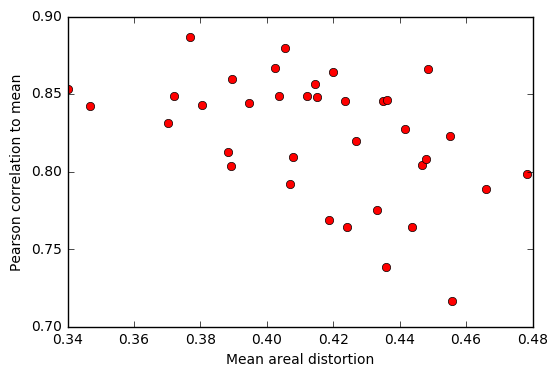

0.49294294444444436
0.834028639691


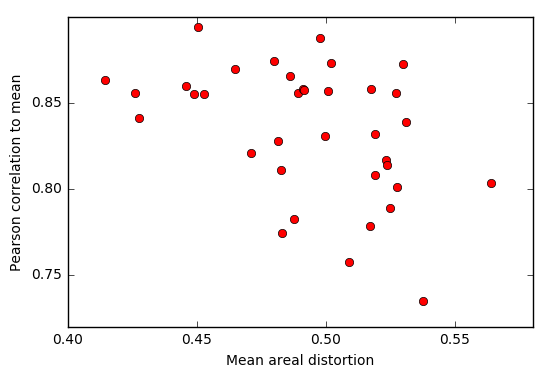

In [56]:
# run msms command
tracers=['az'] #'cumi','dasb','sb','az','C36']
hemi_type=['lh'] #,'rh']
ico='6'
sm='5'
if ico=='7':
    targ='fsaverage'
else:
    targ='fsaverage'+ico
levels=3 # change to 10 later

# define config file, see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MSM/UserGuide for details
configFile = opj(msmDir_proc,'msm_sulc_depth.config')

# Procedure 
# 4) repeat the steps 1-3 below for a number of steps
for level in range(1,levels):
    fs.assert_dir(opj(msmDir_analysis,'level'+str(level))) 
    # 1) use sulc aligned functional data on the spherical mesh and align the single subject once given 
    # definition of spherical mesh
    for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
        subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
        for hemi in hemi_type:
            inmesh_file = opj('/usr/local/nru/freesurfer/subjects',targ,'surf/'+hemi+'.sphere.shape.gii')
            for subj in subjlist:
                outDir = opj(msmDir_analysis,'level'+str(level),subj + '.ico' + ico + '.' +hemi +'.sm' + sm+'/') # msm needs dash at end of outputdir
                fs.assert_dir(outDir)           
                log_file=open(opj(outDir,subj + '.ico' + ico  + '.' +hemi +'.sm' + sm +'.log'),'w')
                indata_file = opj(msmDir_data,'level1',subj + '.ico' + ico  + '.' +hemi +'.sm' + sm + '.txt')
                refdata_file = opj(msmDir_data,'level'+str(level),
                                   tracer + '.mean.ico' + ico + '.' +hemi +'.sm' + sm + '.txt')            
                
                # append the binary mask for the medial wall
                if level==1:
                    refdata_file = opj(msmDir_data,'level'+str(level),
                                       tracer + '.mean.ico' + ico + '.' +hemi +'.sm' + sm + '.txt')            
                    print('nothing')
                    p=Popen([msmDir_code+'/msm','--indata='+indata_file,'--refdata='+refdata_file,'--inmesh='+inmesh_file,
                                '--out='+outDir,'--conf='+configFile,'-v'],stdout=log_file, stderr=log_file)
                else:
                    refdata_file = opj(msmDir_analysis,'level'+str(level-1),
                                       tracer + '.mean.ico' + ico + '.' +hemi +'.sm' + sm + '.new.txt')            
                    transFile = opj(msmDir_analysis,'level'+str(level-1),subj + '.ico' + ico + '.' +hemi +'.sm' + sm,
                                    'sphere.reg.surf.gii')
                    p=Popen([msmDir_code+'/msm','--indata='+indata_file,'--refdata='+refdata_file,
                             '--inmesh='+inmesh_file, '--out='+outDir,'--conf='+configFile,'--trans='+transFile,'-v'],
                            stdout=log_file, stderr=log_file)

                p.communicate()
                log_file.close()
                
    # 2) transform functional data on each subject and redefine an atlas based on the transformed subjects
    # in the msm output folder there is already a file called resampledandprojected.func.gii which is the input data 
    # passed through the MSM warp and projected onto the target surface (useful for vertex-wise comparison with the target). 
    for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
        subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
        for hemi in hemi_type:
            data=np.ndarray(len(subjlist),dtype=object)
            for subj,ns in zip(subjlist,np.arange(0,len(subjlist))):        
                outDir = opj(msmDir_analysis,'level'+str(level),subj + '.ico' + ico + '.' +hemi +'.sm' + sm) 
                fs.assert_dir(outDir) 
                fname=opj(outDir,'transformed_and_reprojected.func.gii')
                gstruct = nib.load(fname)
                data[ns]=gstruct.darrays[0].data

            # Save new mean out
            mean_data = np.vstack(data).mean(axis=0)
            fname2=opj(msmDir_analysis,'level'+str(level),tracer+'.mean.ico' + ico + '.' +hemi +'.sm' + sm+'.new.txt')
            np.savetxt(fname2,mean_data,fmt='%.10f')
            # save as nii too
            fname3=opj(msmDir_analysis,'level'+str(level),tracer+'.mean.ico' + ico + '.' +hemi +'.sm' + sm+'.new.nii.gz')
            fs.save_surf_data(mean_data,fname3)
            
    # 3) evaluate areal distortion and correlation
    for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
        subjlist=petID[np.array([re.search('^'+tracer,x) is not None for x in petID])]
        for hemi in hemi_type:
            inmesh_file = opj('/usr/local/nru/freesurfer/subjects',targ,'surf/'+hemi+'.sphere.shape.gii')
            areal_dist=np.ndarray(len(subjlist),dtype=object)
            subj_mean_corr=np.ndarray(len(subjlist),dtype=object)
            for subj,ns in zip(subjlist,np.arange(0,len(subjlist))): 
                outDir = opj(msmDir_analysis,'level'+str(level),subj + '.ico' + ico + '.' +hemi +'.sm' + sm+'/') # msm needs dash at end of outputdir
                fs.assert_dir(outDir) 
                log_file_name = opj(outDir,subj + '.ico' + ico  + '.' +hemi +'.sm' + sm +'.distortion.log')
                log_file=open(log_file_name,'w')
                transformedmesh_file = opj(outDir,'sphere.reg.surf.gii')
                # areal distortion
                p=Popen([msmDir_code+'/estimate_metric_distortion',inmesh_file,transformedmesh_file,outDir,'-abs'],stdout=log_file, stderr=log_file)
                p.communicate()
                log_file.close()
                # extract mean areal distortion from log file
                with open(log_file_name) as f:
                    f = f.readlines()
                for line in f:   
                     if "mean=" in line:
                            pos = line.find('=')
                            areal_dist[ns] = float(line[pos+1:pos+9])
                            break


                # correlation
                # load individual transformed surfaces and new mean and calculate Pearson correlation coefficient
                fname_ind=opj(outDir,'transformed_and_reprojected.func.gii')
                gstruct = nib.load(fname_ind)
                data1=gstruct.darrays[0].data
                fname_mean=opj(msmDir_analysis,'level'+str(level),tracer+'.mean.ico' + ico + '.' +hemi +'.sm' + sm+'.new.txt')
                data2 = np.loadtxt(fname_mean)
                c = np.corrcoef(data1,data2)
                subj_mean_corr[ns] = c[0][1]

        # print the mean areal distortion and correlation to mean over all single subjects for a given tracer
        print(np.mean(areal_dist))
        print(np.mean(subj_mean_corr))

        # show areal distortion and correlation to mean over all single subjects for a given tracer
        fig = plt.figure()
        plt.plot(areal_dist,subj_mean_corr,'ro')
        plt.xlabel('Mean areal distortion')
        plt.ylabel('Pearson correlation to mean')
        plt.show()
    
   